In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [3]:
# !unzip '/content/drive/MyDrive/Kaggle_dataset.zip' -d '/content/drive/MyDrive/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dataset/images/1479502279230178611.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502279730506173.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502280230536426.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502280730839737.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502281729824146.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502282229848985.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502282730102580.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502283731724690.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502284232432719.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502285221790200.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502285730163274.jpg  
  inflating: /content/drive/MyDrive/dataset/images/1479502286231098378.jpg  
  inflating: /content/dri

In [1]:
import os

len(os.listdir('/content/drive/MyDrive/dataset/images/'))

22241

In [103]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from skimage.feature import hog

import PIL
import cv2
import pickle
from joblib import dump, load
from google.colab.patches import cv2_imshow

## SVM for class = 1: Car

In [31]:
traindf = pd.read_csv('/content/drive/MyDrive/dataset/labels_train.csv')
testdf = pd.read_csv('/content/drive/MyDrive/dataset/labels_val.csv')
car_train_df = traindf[traindf['class_id'] == 1]
car_train_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
2,1478019953180167674.jpg,218,231,146,158,1
4,1478019953689774621.jpg,179,191,144,155,1
5,1478019953689774621.jpg,206,220,145,156,1
6,1478019953689774621.jpg,385,420,122,152,1
...,...,...,...,...,...,...
132401,1479506176491553178.jpg,166,186,139,156,1
132402,1479506176491553178.jpg,182,204,142,153,1
132403,1479506176491553178.jpg,239,261,139,155,1
132404,1479506176491553178.jpg,259,280,139,157,1


In [32]:
not_car_train_df = traindf[traindf['class_id'] != 1]
not_car_train_df

,frame,xmin,xmax,ymin,ymax,class_id
1,1478019952686311006.jpg,437,454,120,186,3
3,1478019953689774621.jpg,171,182,141,154,2
8,1478019954186238236.jpg,165,177,140,154,2
13,1478019954685370994.jpg,160,173,140,153,2
17,1478019955185244088.jpg,154,169,139,153,2
...,...,...,...,...,...,...
132315,1479506169996887187.jpg,265,312,128,176,2
132325,1479506170991708816.jpg,338,438,121,199,2
132326,1479506170991708816.jpg,344,375,105,168,3
132338,1479506171493549745.jpg,419,478,150,232,2


In [33]:
car_test_df = testdf[testdf['class_id'] == 1]
car_test_df

,frame,xmin,xmax,ymin,ymax,class_id
1,1478899046136829030.jpg,203,210,150,158,1
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
5,1478899046136829030.jpg,236,262,145,168,1
7,1478899046707290405.jpg,205,213,152,159,1
...,...,...,...,...,...,...
32693,1479498536475329921.jpg,174,356,97,253,1
32694,1479498536475329921.jpg,337,350,136,150,1
32696,1479498536475329921.jpg,365,385,136,147,1
32697,1479498536475329921.jpg,398,432,134,144,1


In [34]:
not_car_test_df = testdf[testdf['class_id'] != 1]
not_car_test_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
2,1478899046136829030.jpg,215,219,130,135,5
6,1478899046707290405.jpg,202,207,130,136,5
8,1478899046707290405.jpg,217,221,130,137,5
13,1478899047280067376.jpg,199,204,128,134,5
...,...,...,...,...,...,...
32677,1479498534974335830.jpg,361,437,120,147,2
32684,1479498535975181660.jpg,152,211,93,150,2
32686,1479498535975181660.jpg,357,438,122,146,2
32692,1479498536475329921.jpg,152,209,92,147,2


In [35]:
def get_image_path(x):
  path = '/content/drive/MyDrive/dataset/images/' + x
  return path

In [36]:
new_car_train_df = []

curr_frame = car_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(car_train_df)-1):
  if curr_frame == car_train_df.iloc[i]['frame']:
    area = (car_train_df.iloc[i]['xmax'] - car_train_df.iloc[i]['xmin'])*(car_train_df.iloc[i]['ymax'] - car_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = car_train_df.iloc[i]
  if car_train_df.iloc[i+1]['frame'] != curr_frame:
    new_car_train_df.append(max_frame)
    max_area = 0
    curr_frame = car_train_df.iloc[i+1]['frame']


len(new_car_train_df)

Streaming output truncated to the last 5000 lines.
96313
96314
96315
96316
96317
96318
96319
96320
96321
96322
96323
96324
96325
96326
96327
96328
96329
96330
96331
96332
96333
96334
96335
96336
96337
96338
96339
96340
96341
96342
96343
96344
96345
96346
96347
96348
96349
96350
96351
96352
96353
96354
96355
96356
96357
96358
96359
96360
96361
96362
96363
96364
96365
96366
96367
96368
96369
96370
96371
96372
96373
96374
96375
96376
96377
96378
96379
96380
96381
96382
96383
96384
96385
96386
96387
96388
96389
96390
96391
96392
96393
96394
96395
96396
96397
96398
96399
96400
96401
96402
96403
96404
96405
96406
96407
96408
96409
96410
96411
96412
96413
96414
96415
96416
96417
96418
96419
96420
96421
96422
96423
96424
96425
96426
96427
96428
96429
96430
96431
96432
96433
96434
96435
96436
96437
96438
96439
96440
96441
96442
96443
96444
96445
96446
96447
96448
96449
96450
96451
96452
96453
96454
96455
96456
96457
96458
96459
96460
96461
96462
96463
96464
96465
96466
96467
96468
96469
96470
9

17694

In [37]:
new_car_test_df = []

curr_frame = car_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(car_test_df)-1):
  if curr_frame == car_test_df.iloc[i]['frame']:
    area = (car_test_df.iloc[i]['xmax'] - car_test_df.iloc[i]['xmin'])*(car_test_df.iloc[i]['ymax'] - car_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = car_test_df.iloc[i]
  if car_test_df.iloc[i+1]['frame'] != curr_frame:
    new_car_test_df.append(max_frame)
    max_area = 0
    curr_frame = car_test_df.iloc[i+1]['frame']


len(new_car_test_df)

4187

In [38]:
new_not_car_train_df = []

curr_frame = not_car_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_car_train_df)-1):
  if curr_frame == not_car_train_df.iloc[i]['frame']:
    area = (not_car_train_df.iloc[i]['xmax'] - not_car_train_df.iloc[i]['xmin'])*(not_car_train_df.iloc[i]['ymax'] - not_car_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_car_train_df.iloc[i]
  if not_car_train_df.iloc[i+1]['frame'] != curr_frame:
    new_not_car_train_df.append(max_frame)
    max_area = 0
    curr_frame = not_car_train_df.iloc[i+1]['frame']


len(new_not_car_train_df)

9494

In [39]:
new_not_car_test_df = []

curr_frame = not_car_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_car_test_df)-1):
  if curr_frame == not_car_test_df.iloc[i]['frame']:
    area = (not_car_test_df.iloc[i]['xmax'] - not_car_test_df.iloc[i]['xmin'])*(not_car_test_df.iloc[i]['ymax'] - not_car_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_car_test_df.iloc[i]
  if not_car_test_df.iloc[i+1]['frame'] != curr_frame:
    new_not_car_test_df.append(max_frame)
    max_area = 0
    curr_frame = not_car_test_df.iloc[i+1]['frame']


len(new_not_car_test_df)

2688

In [40]:
new_not_car_test_df[0]

frame       1478899046136829030.jpg
xmin                            201
xmax                            206
ymin                            129
ymax                            135
class_id                          5
Name: 0, dtype: object

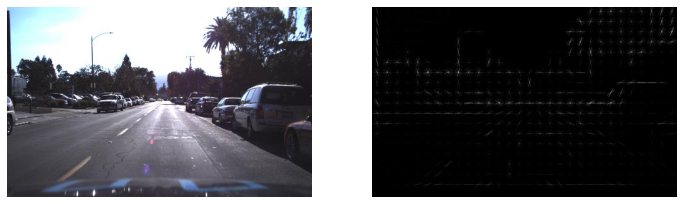

(17748,)

In [100]:
example_image = np.asarray(PIL.Image.open('/content/drive/MyDrive/dataset/images/1479506047979413241.jpg'))
hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True,
                              multichannel=True
                             )

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()
hog_features.shape

In [56]:
not_car_train = []
for i in range(len(new_not_car_train_df)):
  path = new_not_car_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_car_train_df[i]['xmin'],new_not_car_train_df[i]['xmax'], new_not_car_train_df[i]['ymin'], new_not_car_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_car_train.append(img)

len(not_car_train)

9494

In [57]:
car_test = []
for i in range(len(new_car_test_df)):
  path = new_car_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_car_test_df[i]['xmin'],new_car_test_df[i]['xmax'], new_car_test_df[i]['ymin'], new_car_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  car_test.append(img)

len(car_test)

4187

In [62]:


not_car_test = []
for i in range(len(new_not_car_test_df)):
  path = new_not_car_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_car_test_df[i]['xmin'],new_not_car_test_df[i]['xmax'], new_not_car_test_df[i]['ymin'], new_not_car_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_car_test.append(img)

len(not_car_test)

2688

In [63]:
x_train = np.asarray(car_train + not_car_train)
y_train = np.asarray(list(np.ones(len(car_train))) + list(np.zeros(len(not_car_train))))
x_test = np.asarray(car_test + not_car_test)
y_test = np.asarray(list(np.ones(len(car_test))) + list(np.zeros(len(not_car_test))))

In [316]:
X_scaler = StandardScaler().fit(x_train)


In [64]:
svm = SVC()
svm.fit(x_train,y_train)

y_pred = svm.predict(x_test)
print("Accuracy of SVM is ",accuracy_score(y_pred=y_pred,y_true=y_test)*100)

Accuracy of SVM is  93.06181818181818


In [183]:
dump(svm, 'svm_car.joblib')

['svm_car.joblib']

## SVM for class=2:truck

In [98]:
truck_train_df = traindf[traindf['class_id'] == 2]
truck_train_df

,frame,xmin,xmax,ymin,ymax,class_id
3,1478019953689774621.jpg,171,182,141,154,2
8,1478019954186238236.jpg,165,177,140,154,2
13,1478019954685370994.jpg,160,173,140,153,2
17,1478019955185244088.jpg,154,169,139,153,2
22,1478019955679801306.jpg,149,166,138,153,2
...,...,...,...,...,...,...
132269,1479506166991863694.jpg,262,279,138,156,2
132303,1479506168990704654.jpg,226,257,131,161,2
132315,1479506169996887187.jpg,265,312,128,176,2
132325,1479506170991708816.jpg,338,438,121,199,2


In [99]:
not_truck_train_df = traindf[traindf['class_id'] != 2]
not_truck_train_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
4,1478019953689774621.jpg,179,191,144,155,1
5,1478019953689774621.jpg,206,220,145,156,1
...,...,...,...,...,...,...
132401,1479506176491553178.jpg,166,186,139,156,1
132402,1479506176491553178.jpg,182,204,142,153,1
132403,1479506176491553178.jpg,239,261,139,155,1
132404,1479506176491553178.jpg,259,280,139,157,1


In [100]:
truck_test_df = testdf[testdf['class_id'] == 2]
truck_test_df

,frame,xmin,xmax,ymin,ymax,class_id
19,1478899047851282737.jpg,51,87,146,162,2
31,1478899048421712071.jpg,22,78,151,167,2
42,1478899048993232015.jpg,2,65,148,164,2
57,1478899049563611876.jpg,0,51,143,158,2
72,1478899050135529226.jpg,0,32,140,155,2
...,...,...,...,...,...,...
32677,1479498534974335830.jpg,361,437,120,147,2
32684,1479498535975181660.jpg,152,211,93,150,2
32686,1479498535975181660.jpg,357,438,122,146,2
32692,1479498536475329921.jpg,152,209,92,147,2


In [101]:
not_truck_test_df = testdf[testdf['class_id'] != 2]
not_truck_test_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
...,...,...,...,...,...,...
32693,1479498536475329921.jpg,174,356,97,253,1
32694,1479498536475329921.jpg,337,350,136,150,1
32696,1479498536475329921.jpg,365,385,136,147,1
32697,1479498536475329921.jpg,398,432,134,144,1


In [102]:
new_truck_train_df = []

curr_frame = truck_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(truck_train_df)-1):
  if curr_frame == truck_train_df.iloc[i]['frame']:
    area = (truck_train_df.iloc[i]['xmax'] - truck_train_df.iloc[i]['xmin'])*(truck_train_df.iloc[i]['ymax'] - truck_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = truck_train_df.iloc[i]
  if truck_train_df.iloc[i+1]['frame'] != curr_frame:
    new_truck_train_df.append(max_frame)
    max_area = 0
    curr_frame = truck_train_df.iloc[i+1]['frame']


len(new_truck_train_df)

4525

In [103]:
new_not_truck_train_df = []

curr_frame = not_truck_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_truck_train_df)-1):
  if curr_frame == not_truck_train_df.iloc[i]['frame']:
    area = (not_truck_train_df.iloc[i]['xmax'] - not_truck_train_df.iloc[i]['xmin'])*(not_truck_train_df.iloc[i]['ymax'] - not_truck_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_truck_train_df.iloc[i]
  if not_truck_train_df.iloc[i+1]['frame'] != curr_frame:
    new_not_truck_train_df.append(max_frame)
    max_area = 0
    curr_frame = not_truck_train_df.iloc[i+1]['frame']


len(new_not_truck_train_df)

17883

In [104]:
new_truck_test_df = []

curr_frame = truck_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(truck_test_df)-1):
  if curr_frame == truck_test_df.iloc[i]['frame']:
    area = (truck_test_df.iloc[i]['xmax'] - truck_test_df.iloc[i]['xmin'])*(truck_test_df.iloc[i]['ymax'] - truck_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = truck_test_df.iloc[i]
  if truck_test_df.iloc[i+1]['frame'] != curr_frame:
    new_truck_test_df.append(max_frame)
    max_area = 0
    curr_frame = truck_test_df.iloc[i+1]['frame']


len(new_truck_test_df)

855

In [105]:
new_not_truck_test_df = []

curr_frame = not_truck_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_truck_test_df)-1):
  if curr_frame == not_truck_test_df.iloc[i]['frame']:
    area = (not_truck_test_df.iloc[i]['xmax'] - not_truck_test_df.iloc[i]['xmin'])*(not_truck_test_df.iloc[i]['ymax'] - not_truck_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_truck_test_df.iloc[i]
  if not_truck_test_df.iloc[i+1]['frame'] != curr_frame:
    new_not_truck_test_df.append(max_frame)
    max_area = 0
    curr_frame = not_truck_test_df.iloc[i+1]['frame']


len(new_not_truck_test_df)

4235

In [107]:
truck_train = []
print(len(new_truck_train_df))
for i in range(len(new_truck_train_df)):
  path = new_truck_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_truck_train_df[i]['xmin'],new_truck_train_df[i]['xmax'], new_truck_train_df[i]['ymin'], new_truck_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  truck_train.append(img)
len(truck_train)

4525


4525

In [195]:
not_truck_train = []
for i in range(len(new_not_truck_train_df)):
  path = new_not_truck_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_truck_train_df[i]['xmin'],new_not_truck_train_df[i]['xmax'], new_not_truck_train_df[i]['ymin'], new_not_truck_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_truck_train.append(img)

truck_test = []
for i in range(len(new_truck_test_df)):
  path = new_truck_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_truck_test_df[i]['xmin'],new_truck_test_df[i]['xmax'], new_truck_test_df[i]['ymin'], new_truck_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  truck_test.append(img)

not_truck_test = []
for i in range(len(new_not_truck_test_df)):
  path = new_not_truck_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_truck_test_df[i]['xmin'],new_not_truck_test_df[i]['xmax'], new_not_truck_test_df[i]['ymin'], new_not_truck_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_truck_test.append(img)

In [109]:
print(len(not_truck_train),len(not_truck_test), len(truck_test))

17883 4235 855


In [110]:
x_train_truck = np.asarray(truck_train + not_truck_train)
y_train_truck = np.asarray(list(np.ones(len(truck_train))) + list(np.zeros(len(not_truck_train))))
x_test_truck = np.asarray(truck_test + not_truck_test)
y_test_truck = np.asarray(list(np.ones(len(truck_test))) + list(np.zeros(len(not_truck_test))))

In [111]:
svm_truck = SVC()
svm_truck.fit(x_train_truck,y_train_truck)

y_pred_truck = svm_truck.predict(x_test_truck)
print("Accuracy of SVM is ",accuracy_score(y_pred=y_pred_truck,y_true=y_test_truck)*100)

Accuracy of SVM is  93.39882121807466


In [182]:
dump(svm_truck, 'svm_truck.joblib')

['svm_truck.joblib']

## SVM for class=3: Pedestrian

In [112]:
ped_train_df = traindf[traindf['class_id'] == 3]
ped_train_df

,frame,xmin,xmax,ymin,ymax,class_id
1,1478019952686311006.jpg,437,454,120,186,3
63,1478019961680640592.jpg,264,271,139,155,3
69,1478019962181150666.jpg,268,275,138,156,3
76,1478019962681840550.jpg,271,280,137,156,3
82,1478019963181283434.jpg,278,287,138,158,3
...,...,...,...,...,...,...
132291,1479506168470775690.jpg,232,243,140,163,3
132302,1479506168990704654.jpg,225,241,133,154,3
132314,1479506169996887187.jpg,263,282,127,161,3
132326,1479506170991708816.jpg,344,375,105,168,3


In [113]:
not_ped_train_df = traindf[traindf['class_id'] != 3]
not_ped_train_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1
5,1478019953689774621.jpg,206,220,145,156,1
...,...,...,...,...,...,...
132401,1479506176491553178.jpg,166,186,139,156,1
132402,1479506176491553178.jpg,182,204,142,153,1
132403,1479506176491553178.jpg,239,261,139,155,1
132404,1479506176491553178.jpg,259,280,139,157,1


In [114]:
ped_test_df = testdf[testdf['class_id'] == 3]
ped_test_df

,frame,xmin,xmax,ymin,ymax,class_id
937,1478899115833601736.jpg,81,89,154,173,3
941,1478899116405508898.jpg,65,74,151,170,3
945,1478899116976239583.jpg,47,55,153,175,3
973,1478899120405194200.jpg,87,94,154,171,3
976,1478899120975132923.jpg,68,76,153,170,3
...,...,...,...,...,...,...
32588,1479498528474014347.jpg,325,337,132,153,3
32619,1479498529976231369.jpg,338,348,125,160,3
32631,1479498530974572264.jpg,343,356,126,159,3
32649,1479498532973398850.jpg,338,347,133,147,3


In [115]:
not_ped_test_df = testdf[testdf['class_id'] != 3]
not_ped_test_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
...,...,...,...,...,...,...
32694,1479498536475329921.jpg,337,350,136,150,1
32695,1479498536475329921.jpg,360,441,117,147,2
32696,1479498536475329921.jpg,365,385,136,147,1
32697,1479498536475329921.jpg,398,432,134,144,1


In [116]:
new_ped_train_df = []

curr_frame = ped_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(ped_train_df)-1):
  if curr_frame == ped_train_df.iloc[i]['frame']:
    area = (ped_train_df.iloc[i]['xmax'] - ped_train_df.iloc[i]['xmin'])*(ped_train_df.iloc[i]['ymax'] - ped_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = ped_train_df.iloc[i]
  if ped_train_df.iloc[i+1]['frame'] != curr_frame:
    new_ped_train_df.append(max_frame)
    max_area = 0
    curr_frame = ped_train_df.iloc[i+1]['frame']


len(new_ped_train_df)

4065

In [117]:
new_not_ped_train_df = []

curr_frame = not_ped_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_ped_train_df)-1):
  if curr_frame == not_ped_train_df.iloc[i]['frame']:
    area = (not_ped_train_df.iloc[i]['xmax'] - not_ped_train_df.iloc[i]['xmin'])*(not_ped_train_df.iloc[i]['ymax'] - not_ped_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_ped_train_df.iloc[i]
  if not_ped_train_df.iloc[i+1]['frame'] != curr_frame:
    new_not_ped_train_df.append(max_frame)
    max_area = 0
    curr_frame = not_ped_train_df.iloc[i+1]['frame']


len(new_not_ped_train_df)

17938

In [118]:
new_ped_test_df = []

curr_frame = ped_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(ped_test_df)-1):
  if curr_frame == ped_test_df.iloc[i]['frame']:
    area = (ped_test_df.iloc[i]['xmax'] - ped_test_df.iloc[i]['xmin'])*(ped_test_df.iloc[i]['ymax'] - ped_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = ped_test_df.iloc[i]
  if ped_test_df.iloc[i+1]['frame'] != curr_frame:
    new_ped_test_df.append(max_frame)
    max_area = 0
    curr_frame = ped_test_df.iloc[i+1]['frame']


len(new_ped_test_df)

1369

In [119]:
new_not_ped_test_df = []

curr_frame = not_ped_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_ped_test_df)-1):
  if curr_frame == not_ped_test_df.iloc[i]['frame']:
    area = (not_ped_test_df.iloc[i]['xmax'] - not_ped_test_df.iloc[i]['xmin'])*(not_ped_test_df.iloc[i]['ymax'] - not_ped_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_ped_test_df.iloc[i]
  if not_ped_test_df.iloc[i+1]['frame'] != curr_frame:
    new_not_ped_test_df.append(max_frame)
    max_area = 0
    curr_frame = not_ped_test_df.iloc[i+1]['frame']


len(new_not_ped_test_df)

4232

In [120]:
ped_train = []
print(len(new_ped_train_df))
for i in range(len(new_ped_train_df)):
  path = new_ped_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_ped_train_df[i]['xmin'],new_ped_train_df[i]['xmax'], new_ped_train_df[i]['ymin'], new_ped_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  ped_train.append(img)
len(ped_train)

4065


4065

In [122]:
not_ped_train = []
print(len(new_not_ped_train_df))
for i in range(len(new_not_ped_train_df)):
  path = new_not_ped_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_ped_train_df[i]['xmin'],new_not_ped_train_df[i]['xmax'], new_not_ped_train_df[i]['ymin'], new_not_ped_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_ped_train.append(img)
len(not_ped_train)

17938


17938

In [123]:
ped_test = []
print(len(new_ped_test_df))
for i in range(len(new_ped_test_df)):
  path = new_ped_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_ped_test_df[i]['xmin'],new_ped_test_df[i]['xmax'], new_ped_test_df[i]['ymin'], new_ped_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  ped_test.append(img)
len(ped_test)

1369


1369

In [124]:
not_ped_test = []
print(len(new_not_ped_test_df))
for i in range(len(new_not_ped_test_df)):
  path = new_not_ped_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_ped_test_df[i]['xmin'],new_not_ped_test_df[i]['xmax'], new_not_ped_test_df[i]['ymin'], new_not_ped_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_ped_test.append(img)
len(not_ped_test)

4232


4232

In [125]:
x_train_ped = np.asarray(ped_train + not_ped_train)
y_train_ped = np.asarray(list(np.ones(len(ped_train))) + list(np.zeros(len(not_ped_train))))
x_test_ped = np.asarray(ped_test + not_ped_test)
y_test_ped = np.asarray(list(np.ones(len(ped_test))) + list(np.zeros(len(not_ped_test))))

svm_ped = SVC()
svm_ped.fit(x_train_ped,y_train_ped)

y_pred_ped = svm_ped.predict(x_test_ped)
print("Accuracy of SVM is ",accuracy_score(y_pred=y_pred_ped,y_true=y_test_ped)*100)

Accuracy of SVM is  95.62578111051599


In [181]:
dump(svm_ped, 'svm_pedestrian.joblib')

['svm_pedestrian.joblib']

## SVM for class 4: bicyclist

In [126]:
bi_train_df = traindf[traindf['class_id'] == 4]
bi_train_df

,frame,xmin,xmax,ymin,ymax,class_id
159,1478019971686116476.jpg,146,159,142,151,4
166,1478019971686116476.jpg,214,227,135,150,4
169,1478019972180014279.jpg,124,138,142,152,4
181,1478019972685986697.jpg,104,117,141,152,4
194,1478019973185520968.jpg,83,97,141,153,4
...,...,...,...,...,...,...
62902,1478899039280861122.jpg,285,293,148,170,4
62904,1478899039280861122.jpg,343,353,142,174,4
62917,1478899039853034997.jpg,303,311,144,173,4
62932,1478899040423223085.jpg,333,344,141,174,4


In [127]:
not_bi_train_df = traindf[traindf['class_id'] != 4]
not_bi_train_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1
...,...,...,...,...,...,...
132401,1479506176491553178.jpg,166,186,139,156,1
132402,1479506176491553178.jpg,182,204,142,153,1
132403,1479506176491553178.jpg,239,261,139,155,1
132404,1479506176491553178.jpg,259,280,139,157,1


In [128]:
bi_test_df = testdf[testdf['class_id'] == 4]
bi_test_df

,frame,xmin,xmax,ymin,ymax,class_id
1295,1478899146683058208.jpg,323,332,148,165,4
1318,1478899147254573995.jpg,322,331,148,165,4
1342,1478899147826809942.jpg,317,327,146,162,4
1363,1478899148397330410.jpg,314,322,145,165,4
1379,1478899148968408269.jpg,307,318,148,167,4
...,...,...,...,...,...,...
29255,1478901424415630818.jpg,397,408,146,158,4
29282,1478901430700594963.jpg,39,49,159,177,4
29285,1478901431270894331.jpg,43,62,159,173,4
29288,1478901431842569475.jpg,25,46,161,177,4


In [131]:
not_bi_test_df = testdf[testdf['class_id'] != 4]
not_bi_test_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
...,...,...,...,...,...,...
32694,1479498536475329921.jpg,337,350,136,150,1
32695,1479498536475329921.jpg,360,441,117,147,2
32696,1479498536475329921.jpg,365,385,136,147,1
32697,1479498536475329921.jpg,398,432,134,144,1


In [132]:
new_bi_train_df = []

curr_frame = bi_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(bi_train_df)-1):
  if curr_frame == bi_train_df.iloc[i]['frame']:
    area = (bi_train_df.iloc[i]['xmax'] - bi_train_df.iloc[i]['xmin'])*(bi_train_df.iloc[i]['ymax'] - bi_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = bi_train_df.iloc[i]
  if bi_train_df.iloc[i+1]['frame'] != curr_frame:
    new_bi_train_df.append(max_frame)
    max_area = 0
    curr_frame = bi_train_df.iloc[i+1]['frame']


len(new_bi_train_df)

909

In [133]:
new_not_bi_train_df = []

curr_frame = not_bi_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_bi_train_df)-1):
  if curr_frame == not_bi_train_df.iloc[i]['frame']:
    area = (not_bi_train_df.iloc[i]['xmax'] - not_bi_train_df.iloc[i]['xmin'])*(not_bi_train_df.iloc[i]['ymax'] - not_bi_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_bi_train_df.iloc[i]
  if not_bi_train_df.iloc[i+1]['frame'] != curr_frame:
    new_not_bi_train_df.append(max_frame)
    max_area = 0
    curr_frame = not_bi_train_df.iloc[i+1]['frame']
  if len(new_not_bi_train_df) > 1200:
    break


len(new_not_bi_train_df)

1201

In [134]:
new_bi_test_df = []

curr_frame = bi_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(bi_test_df)-1):
  if curr_frame == bi_test_df.iloc[i]['frame']:
    area = (bi_test_df.iloc[i]['xmax'] - bi_test_df.iloc[i]['xmin'])*(bi_test_df.iloc[i]['ymax'] - bi_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = bi_test_df.iloc[i]
  if bi_test_df.iloc[i+1]['frame'] != curr_frame:
    new_bi_test_df.append(max_frame)
    max_area = 0
    curr_frame = bi_test_df.iloc[i+1]['frame']


len(new_bi_test_df)

165

In [135]:
new_not_bi_test_df = []

curr_frame = not_bi_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_bi_test_df)-1):
  if curr_frame == not_bi_test_df.iloc[i]['frame']:
    area = (not_bi_test_df.iloc[i]['xmax'] - not_bi_test_df.iloc[i]['xmin'])*(not_bi_test_df.iloc[i]['ymax'] - not_bi_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_bi_test_df.iloc[i]
  if not_bi_test_df.iloc[i+1]['frame'] != curr_frame:
    new_not_bi_test_df.append(max_frame)
    max_area = 0
    curr_frame = not_bi_test_df.iloc[i+1]['frame']
  if len(new_not_bi_test_df) > 400:
    break


len(new_not_bi_test_df)

401

In [136]:
bi_train = []
print(len(new_bi_train_df))
for i in range(len(new_bi_train_df)):
  path = new_bi_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_bi_train_df[i]['xmin'],new_bi_train_df[i]['xmax'], new_bi_train_df[i]['ymin'], new_bi_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  bi_train.append(img)

not_bi_train = []
for i in range(len(new_not_bi_train_df)):
  path = new_not_bi_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_bi_train_df[i]['xmin'],new_not_bi_train_df[i]['xmax'], new_not_bi_train_df[i]['ymin'], new_not_bi_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_bi_train.append(img)

bi_test = []
for i in range(len(new_bi_test_df)):
  path = new_bi_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_bi_test_df[i]['xmin'],new_bi_test_df[i]['xmax'], new_bi_test_df[i]['ymin'], new_bi_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  bi_test.append(img)

not_bi_test = []
for i in range(len(new_not_bi_test_df)):
  path = new_not_bi_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_bi_test_df[i]['xmin'],new_not_bi_test_df[i]['xmax'], new_not_bi_test_df[i]['ymin'], new_not_bi_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_bi_test.append(img)


print(len(bi_train), len(not_bi_train), len(bi_test), len(not_bi_test))

909
909 1201 165 401


In [137]:
x_train_bi = np.asarray(bi_train + not_bi_train)
y_train_bi = np.asarray(list(np.ones(len(bi_train))) + list(np.zeros(len(not_bi_train))))
x_test_bi = np.asarray(bi_test + not_bi_test)
y_test_bi = np.asarray(list(np.ones(len(bi_test))) + list(np.zeros(len(not_bi_test))))

svm_bi = SVC()
svm_bi.fit(x_train_bi,y_train_bi)

y_pred_bi = svm_bi.predict(x_test_bi)
print("Accuracy of SVM is ",accuracy_score(y_pred=y_pred_bi,y_true=y_test_bi)*100)

Accuracy of SVM is  96.81978798586573


In [180]:
dump(svm_bi, 'svm_bicyclist.joblib')

['svm_bicyclist.joblib']

## SVM for class 5: light

In [138]:
lt_train_df = traindf[traindf['class_id'] == 5]
lt_train_df

,frame,xmin,xmax,ymin,ymax,class_id
100,1478019965181415731.jpg,230,235,127,135,5
105,1478019965682301515.jpg,231,237,127,135,5
110,1478019966187511711.jpg,231,237,126,135,5
115,1478019966688931929.jpg,233,238,126,134,5
119,1478019967180239928.jpg,230,236,125,134,5
...,...,...,...,...,...,...
62975,1478899044422493989.jpg,213,216,136,141,5
62979,1478899044994853854.jpg,201,205,133,140,5
62981,1478899044994853854.jpg,213,217,134,140,5
62985,1478899045564925635.jpg,201,206,132,138,5


In [139]:
not_lt_train_df = traindf[traindf['class_id'] != 5]
not_lt_train_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1
...,...,...,...,...,...,...
132401,1479506176491553178.jpg,166,186,139,156,1
132402,1479506176491553178.jpg,182,204,142,153,1
132403,1479506176491553178.jpg,239,261,139,155,1
132404,1479506176491553178.jpg,259,280,139,157,1


In [140]:
lt_test_df = testdf[testdf['class_id'] == 5]
lt_test_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
2,1478899046136829030.jpg,215,219,130,135,5
6,1478899046707290405.jpg,202,207,130,136,5
8,1478899046707290405.jpg,217,221,130,137,5
13,1478899047280067376.jpg,199,204,128,134,5
...,...,...,...,...,...,...
29008,1478901410133420449.jpg,246,253,102,122,5
29016,1478901410133420449.jpg,329,344,70,99,5
29028,1478901410704996327.jpg,273,285,71,91,5
29030,1478901410704996327.jpg,312,325,86,110,5


In [141]:
not_lt_test_df = testdf[testdf['class_id'] != 5]
not_lt_test_df

,frame,xmin,xmax,ymin,ymax,class_id
1,1478899046136829030.jpg,203,210,150,158,1
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
5,1478899046136829030.jpg,236,262,145,168,1
7,1478899046707290405.jpg,205,213,152,159,1
...,...,...,...,...,...,...
32694,1479498536475329921.jpg,337,350,136,150,1
32695,1479498536475329921.jpg,360,441,117,147,2
32696,1479498536475329921.jpg,365,385,136,147,1
32697,1479498536475329921.jpg,398,432,134,144,1


In [142]:
new_lt_train_df = []

curr_frame = lt_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(lt_train_df)-1):
  if curr_frame == lt_train_df.iloc[i]['frame']:
    area = (lt_train_df.iloc[i]['xmax'] - lt_train_df.iloc[i]['xmin'])*(lt_train_df.iloc[i]['ymax'] - lt_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = lt_train_df.iloc[i]
  if lt_train_df.iloc[i+1]['frame'] != curr_frame:
    new_lt_train_df.append(max_frame)
    max_area = 0
    curr_frame = lt_train_df.iloc[i+1]['frame']


len(new_lt_train_df)

3315

In [143]:
new_not_lt_train_df = []

curr_frame = not_lt_train_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_lt_train_df)-1):
  if curr_frame == not_lt_train_df.iloc[i]['frame']:
    area = (not_lt_train_df.iloc[i]['xmax'] - not_lt_train_df.iloc[i]['xmin'])*(not_lt_train_df.iloc[i]['ymax'] - not_lt_train_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_lt_train_df.iloc[i]
  if not_lt_train_df.iloc[i+1]['frame'] != curr_frame:
    new_not_lt_train_df.append(max_frame)
    max_area = 0
    curr_frame = not_lt_train_df.iloc[i+1]['frame']
  if len(new_not_lt_train_df) > 5000:
    break


len(new_not_lt_train_df)

5001

In [144]:
new_lt_test_df = []

curr_frame = lt_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(lt_test_df)-1):
  if curr_frame == lt_test_df.iloc[i]['frame']:
    area = (lt_test_df.iloc[i]['xmax'] - lt_test_df.iloc[i]['xmin'])*(lt_test_df.iloc[i]['ymax'] - lt_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = lt_test_df.iloc[i]
  if lt_test_df.iloc[i+1]['frame'] != curr_frame:
    new_lt_test_df.append(max_frame)
    max_area = 0
    curr_frame = lt_test_df.iloc[i+1]['frame']


len(new_lt_test_df)

1511

In [148]:
new_not_lt_test_df = []

curr_frame = not_lt_test_df.iloc[0]['frame']
max_area = 0
max_frame = any
for i in range(len(not_lt_test_df)-1):
  if curr_frame == not_lt_test_df.iloc[i]['frame']:
    area = (not_lt_test_df.iloc[i]['xmax'] - not_lt_test_df.iloc[i]['xmin'])*(not_lt_test_df.iloc[i]['ymax'] - not_lt_test_df.iloc[i]['ymin'])
    if area > max_area:
      max_area = area
      max_frame = not_lt_test_df.iloc[i]
  if not_lt_test_df.iloc[i+1]['frame'] != curr_frame:
    new_not_lt_test_df.append(max_frame)
    max_area = 0
    curr_frame = not_lt_test_df.iloc[i+1]['frame']
  if len(new_not_lt_test_df) > 2500:
    break


len(new_not_lt_test_df)

2501

In [149]:
lt_train = []
print(len(new_lt_train_df))
for i in range(len(new_lt_train_df)):
  path = new_lt_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_lt_train_df[i]['xmin'],new_lt_train_df[i]['xmax'], new_lt_train_df[i]['ymin'], new_lt_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  lt_train.append(img)

not_lt_train = []
for i in range(len(new_not_lt_train_df)):
  path = new_not_lt_train_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_lt_train_df[i]['xmin'],new_not_lt_train_df[i]['xmax'], new_not_lt_train_df[i]['ymin'], new_not_lt_train_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_lt_train.append(img)

lt_test = []
for i in range(len(new_lt_test_df)):
  path = new_lt_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_lt_test_df[i]['xmin'],new_lt_test_df[i]['xmax'], new_lt_test_df[i]['ymin'], new_lt_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  lt_test.append(img)

not_lt_test = []
for i in range(len(new_not_lt_test_df)):
  path = new_not_lt_test_df[i]['frame']
  img = np.asarray(PIL.Image.open(get_image_path(path)))
  xmin, xmax, ymin, ymax = new_not_lt_test_df[i]['xmin'],new_not_lt_test_df[i]['xmax'], new_not_lt_test_df[i]['ymin'], new_not_lt_test_df[i]['ymax']
  cropped_img = img[ymin:ymax, xmin:xmax]
  img = cv2.cvtColor(cv2.resize(cropped_img,(96,64)),cv2.COLOR_RGB2GRAY)
  img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
  not_lt_test.append(img)


print(len(lt_train), len(not_lt_train), len(lt_test), len(not_lt_test))

3315
3315 5001 1511 2501


In [150]:
x_train_lt = np.asarray(lt_train + not_lt_train)
y_train_lt = np.asarray(list(np.ones(len(lt_train))) + list(np.zeros(len(not_lt_train))))
x_test_lt = np.asarray(lt_test + not_lt_test)
y_test_lt = np.asarray(list(np.ones(len(lt_test))) + list(np.zeros(len(not_lt_test))))

svm_lt = SVC()
svm_lt.fit(x_train_lt,y_train_lt)

y_pred_lt = svm_lt.predict(x_test_lt)
print("Accuracy of SVM is ",accuracy_score(y_pred=y_pred_lt,y_true=y_test_lt)*100)

Accuracy of SVM is  96.08673978065802


## Sliding Window and heatmap

In [45]:
# svm_car = load('svm_car.joblib')
# svm_light = load('svm_light.joblib')
# svm_pedestrian = load('svm_pedestrian.joblib')
# svm_bicyclist = load('svm_bicyclist.joblib')
# svm_truck = load('svm_truck.joblib')

In [5]:
def slideExtract(image,windowSize=(96,64),channel="RGB",step=12):
    
    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")
    
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            features_of_window = hog(window,orientations=9,pixels_per_cell=(16,16),
                                     cells_per_block=(2,2)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [6]:
example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/dataset/images/1479506047979413241.jpg"))
coords,features = slideExtract(example_image,channel="RGB")

coords[:5]

[(0, 96, 0, 64),
 (0, 96, 12, 76),
 (0, 96, 24, 88),
 (0, 96, 36, 100),
 (0, 96, 48, 112)]

In [7]:
features.shape


(640, 540)

In [29]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,140,255)
        
        return self.mask

In [47]:
def detect(image, svm):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision_car = svm.predict([features[i]])

        if decision_car[0] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
        
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

Time required to detect objects:  5.745990037918091


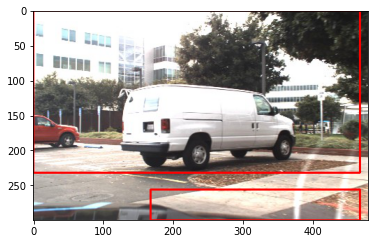

In [97]:
img = np.asarray(PIL.Image.open("/content/drive/MyDrive/dataset/images/1478898556541257115.jpg"))
t = time.time()
detected = detect(img, svm_truck)

plt.imshow(detected)
print("Time required to detect objects: ", time.time() - t)

Time required to detect objects:  4.144823789596558


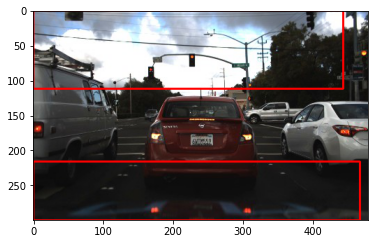

In [98]:
img = np.asarray(PIL.Image.open("/content/drive/MyDrive/dataset/images/1478020981220875260.jpg"))
t = time.time()
detected = detect(img, svm_light)

plt.imshow(detected)
print("Time required to detect objects: ", time.time() - t)

Time required to detect objects:  7.073936700820923


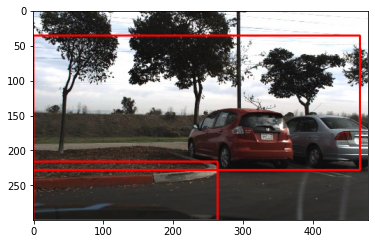

In [90]:

img = np.asarray(PIL.Image.open("/content/drive/MyDrive/dataset/images/1478898533118299190.jpg"))
t = time.time()
detected = detect(img, svm_car)

plt.imshow(detected)
print("Time required to detect objects: ", time.time() - t)

Time required to detect objects:  6.857709646224976


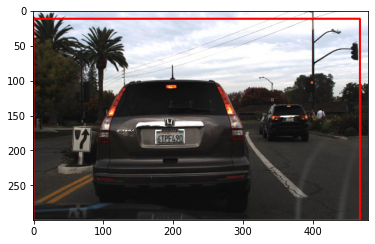

In [94]:

img = np.asarray(PIL.Image.open("/content/drive/MyDrive/dataset/images/1478900929106930851.jpg"))
t = time.time()
detected = detect(img, svm_car)

plt.imshow(detected)
print("Time required to detect objects: ", time.time() - t)